# Import libraries

In [129]:
# Padrão
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Others
import openpyxl
import pathlib
import xlrd
import os
import warnings
import statistics
import category_encoders as ce


In [149]:
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter 
from lifelines.statistics import logrank_test, pairwise_logrank_test
from lifelines import CoxPHFitter

In [131]:
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

In [132]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams["figure.figsize"] = [7.2, 4.8]

# Import Dataset

In [133]:
df_churn_prediction = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv', sep=",", encoding='UTF-8')
df_churn_prediction.shape

(7043, 21)

In [134]:
df_churn_prediction.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


In [135]:
df_churn_prediction['churn'] = [1 if x == 'Yes' else 0 for x in df_churn_prediction['Churn']]
df_churn_prediction.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes,1


In [136]:
df_churn_prediction['churn'].value_counts()

churn
0    5174
1    1869
Name: count, dtype: int64

In [137]:
df_churn_prediction.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'churn'],
      dtype='object')

# Model Building

Text(0.5, 1.0, 'Kaplan-Meier Curve')

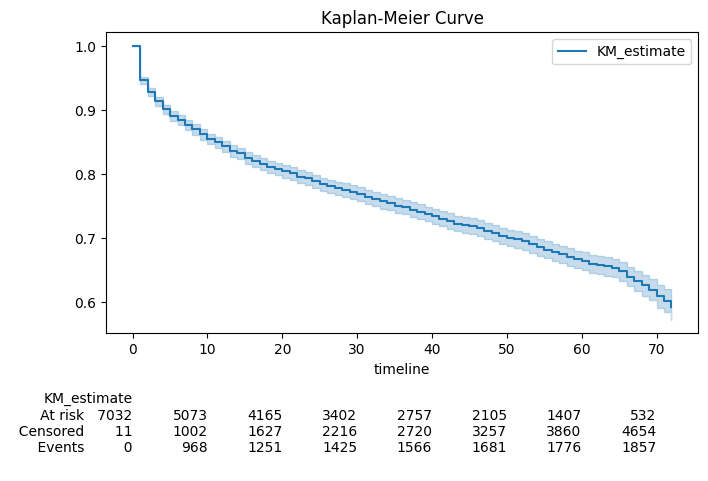

In [138]:
T = df_churn_prediction['tenure'] # months
E = df_churn_prediction['churn']

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

kmf.plot(at_risk_counts=True)
plt.title('Kaplan-Meier Curve')

Text(0.5, 1.0, 'Survival curves by payment method')

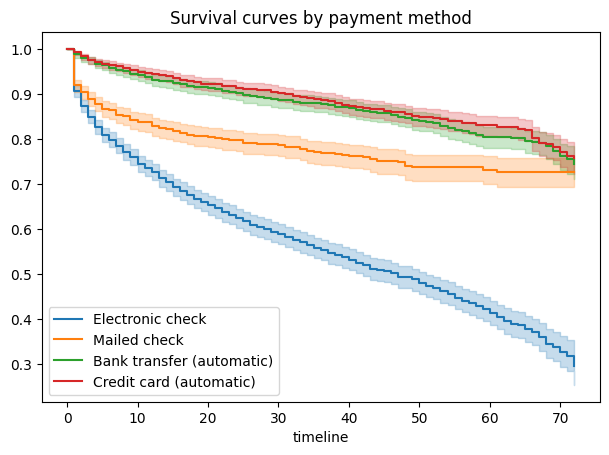

In [139]:
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for payment_method in df_churn_prediction['PaymentMethod'].unique():
    
    flag = df_churn_prediction['PaymentMethod'] == payment_method
    
    kmf.fit(T[flag], event_observed = E[flag], label = payment_method)
    kmf.plot(ax=ax)

plt.title("Survival curves by payment method")

In [140]:
credit_card_flag = df_churn_prediction['PaymentMethod'] == 'Credit card (automatic)'
bank_transfer_flag = df_churn_prediction['PaymentMethod'] == 'Bank transfer (automatic)'

results = logrank_test(T[credit_card_flag], 
                       T[bank_transfer_flag], 
                       E[credit_card_flag], 
                       E[bank_transfer_flag])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.87 0.35      1.51

In [141]:
results = pairwise_logrank_test(df_churn_prediction['tenure'], df_churn_prediction['PaymentMethod'], df_churn_prediction['churn'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                                   test_statistic      p  -log2(p)
Bank transfer (automatic) Credit card (automatic)            0.87   0.35      1.51
                          Electronic check                 510.04 <0.005    372.74
                          Mailed check                      51.07 <0.005     40.03
Credit card (automatic)   Electronic check                 539.74 <0.005    394.21
                          Mailed check                      64.82 <0.005     50.11
Electronic check          Mailed check                     152.46 <0.005    113.93

In [142]:
# process the data for Cox model
id_col = df_churn_prediction['customerID']; df_churn_prediction.drop(['customerID', 'TotalCharges'], axis = 1, inplace = True)
df_churn_prediction = df_churn_prediction[['gender', 'SeniorCitizen', 'Partner','tenure', 'churn', 'PhoneService', 'OnlineSecurity', 'Contract']]
df_churn_prediction = pd.get_dummies(df_churn_prediction, drop_first = True)

# split into training and test
df_train, df_test =  df_churn_prediction.iloc[:-10], df_churn_prediction.iloc[-10:]

cph = CoxPHFitter()

cph.fit(df_train, duration_col='tenure', event_col='churn')

<lifelines.CoxPHFitter: fitted with 7033 total observations, 5166 right-censored observations>

In [143]:
df_train.shape, df_test.shape

((7033, 10), (10, 10))

In [144]:
cph.print_summary(columns=["coef","exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%", "z", "p"], decimals=3)

<lifelines.CoxPHFitter: fitted with 7033 total observations, 5166 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 7033
number of events observed = 1867
   partial log-likelihood = -14141.867
         time fit was run = 2024-07-03 19:35:15 UTC

---
                                     coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%       z       p
covariate                                                                                                     
SeniorCitizen                      -0.034      0.966                0.869                1.075  -0.633   0.527
gender_Male                        -0.056      0.945                0.863                1.035  -1.218   0.223
Partner_Yes                        -0.615      0.541                0.490                0.596 -12.341 <0.0005
PhoneService_Yes                    0.169      1.184                1.011                1.388   2.092   0.036
OnlineSecurity_No internet service -0.747      0.474                0.389                0.577  -7.411 <0.0005
OnlineSecurity_Yes                 -0.786      0.456                0.401                0.518 -12.026 <0.0005
Contract_One year                  -1.966      0.140                0.118                0.165 -23.072 <0.0005
Contract_Two year                  -3.774      0.023                0.017                0.031 -23.470 <0.0005
---
Concordance = 0.829
Partial AIC = 28299.733
log-likelihood ratio test = 2985.035 on 8 df
-log2(p) of ll-ratio test = inf

<Axes: xlabel='log(HR) (95% CI)'>

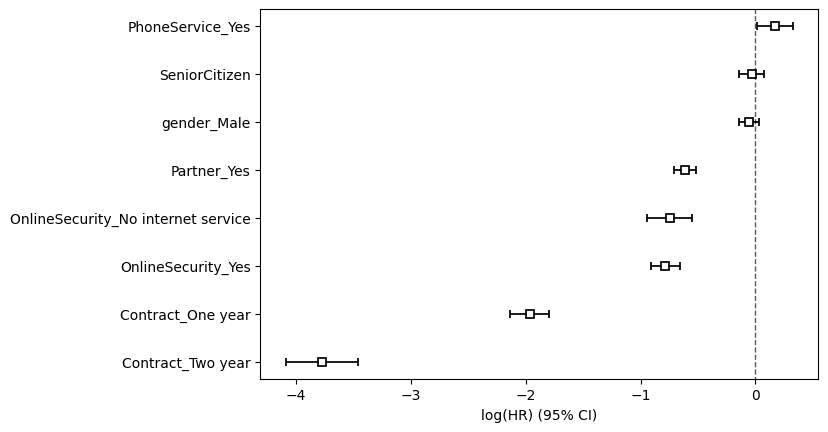

In [145]:
# Lets plot the individual risk factors

cph.plot()

In [146]:
cph.predict_survival_function(df_test)

,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042
0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
1.000,0.874,0.937,0.874,0.983,0.998,0.995,0.989,0.971,0.932,0.999
2.000,0.829,0.913,0.829,0.977,0.998,0.994,0.985,0.960,0.907,0.998
3.000,0.794,0.895,0.794,0.972,0.997,0.992,0.982,0.950,0.886,0.998
4.000,0.762,0.877,0.762,0.967,0.997,0.991,0.978,0.942,0.868,0.997
5.000,0.737,0.863,0.737,0.963,0.996,0.990,0.976,0.935,0.853,0.997
6.000,0.721,0.854,0.721,0.960,0.996,0.989,0.974,0.930,0.843,0.997
7.000,0.700,0.842,0.700,0.956,0.996,0.988,0.972,0.924,0.830,0.996
8.000,0.682,0.832,0.682,0.953,0.996,0.987,0.970,0.919,0.819,0.996
9.000,0.663,0.820,0.663,0.950,0.995,0.986,0.968,0.913,0.807,0.996


<Axes: >

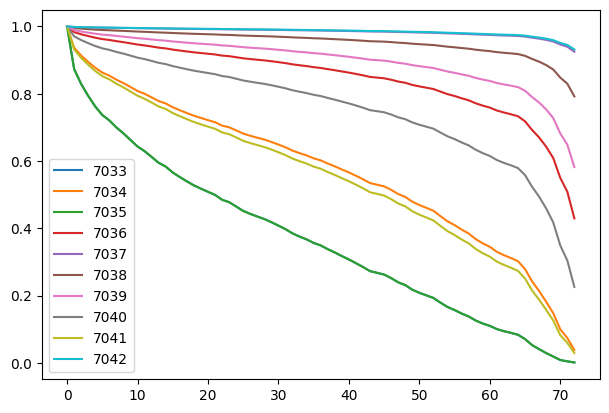

In [147]:
cph.predict_survival_function(df_test).plot()

## FIM